In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Önceden Eğitilmiş Sınıflandırıcıyı İndirme İşlemi

In [2]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #classifier urlsi
IMAGE_RES = 224 #resimlerin boyutu imagenet üzerinde eğitildiği için 224 olmalıdır

model = tf.keras.Sequential([
                             hub.KerasLayer(CLASSIFIER_URL, input_shape = (IMAGE_RES,IMAGE_RES,3))
])

## Dışarıdan Bir Resmi Yükleme ve Görüntüleme İşlemi

163840/150434 [================================] - 0s 0us/step


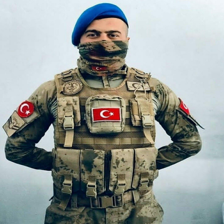

In [3]:
import numpy as np
import PIL.Image as Image

uniform = tf.keras.utils.get_file(origin = 'https://i.pinimg.com/originals/f9/2f/2c/f92f2c40f40dd79c6434cb1e00ae7cd6.jpg')
uniform = Image.open(uniform).resize((IMAGE_RES,IMAGE_RES))
uniform

In [4]:
uniform = np.array(uniform)/255.0 #pixelleri numpy arraye çevirip 0 ile 1 arasında değerlere dönüştürme
uniform.shape

(224, 224, 3)

## Tahmin İşlemi

In [5]:
result = model.predict(uniform[np.newaxis,...]) #model toplu iş boyutu beklediği için ekleme yapıp tahminde bulunma
result.shape

(1, 1001)

In [6]:
tahmin_sınıfı = np.argmax(result[0], axis = -1)
tahmin_sınıfı

466

24576/10484 [======================================================================] - 0s 0us/step


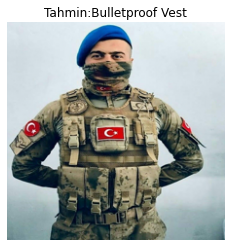

In [7]:
#tahmin sınıfının ne olduğunu bulma
etiket_yolu = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
etiketler = imagenet_labels = np.array(open(etiket_yolu).read().splitlines())

plt.imshow(uniform)
plt.axis('off')
tahmin_edilen_sinif_adi = etiketler[tahmin_sınıfı]
_ = plt.title('Tahmin:' + tahmin_edilen_sinif_adi.title())

# Kedi Köpek Sınıflandırması (Transfer Learning ile)

## Veri Seti

In [8]:
(train_examples, validation_examples), info = tfds.load('cats_vs_dogs',
                                                        with_info = True,
                                                        as_supervised = True,
                                                        split = ['train[:80%]','train[:80%]'])
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes
print(num_examples,num_classes)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete1D2JWM/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.
23262 2


In [9]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1,example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


## Resimlerin Aynı Boyuta Getirilmesi ve Normalize Edilmesi

In [10]:
def format_image(image,label):
  image = tf.image.resize(image, (IMAGE_RES,IMAGE_RES))/255.0
  return image,label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

## Bir İş Boyutu Resmi Tahmin İşlemi

In [11]:
image_batch, label_batch = next(iter(train_batches.take(1))) #eğitim setinden 32 örnek alımı
image_batch = image_batch.numpy() #resimleri numpy çevirme
label_batch = label_batch.numpy() #etiketleri numpy çevirme

result_batch = model.predict(image_batch) #32 resmi tahmin etme

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)] #tahmin edilen resimlerin sınıfları
predicted_class_names

array(['Egyptian cat', 'Persian cat', 'tabby', 'tabby', 'Egyptian cat',
       'red-breasted merganser', 'Staffordshire bullterrier', 'tabby',
       'wire-haired fox terrier', 'cocker spaniel', 'cocker spaniel',
       'beagle', 'leopard', 'tiger cat', 'Border collie', 'Great Dane',
       'tiger cat', 'Egyptian cat', 'Chesapeake Bay retriever',
       'Brittany spaniel', 'Egyptian cat', 'Persian cat', 'tabby',
       'tabby', 'tabby', 'English springer', 'flat-coated retriever',
       'kelpie', 'Persian cat', 'miniature poodle', 'tabby',
       'Persian cat'], dtype='<U30')

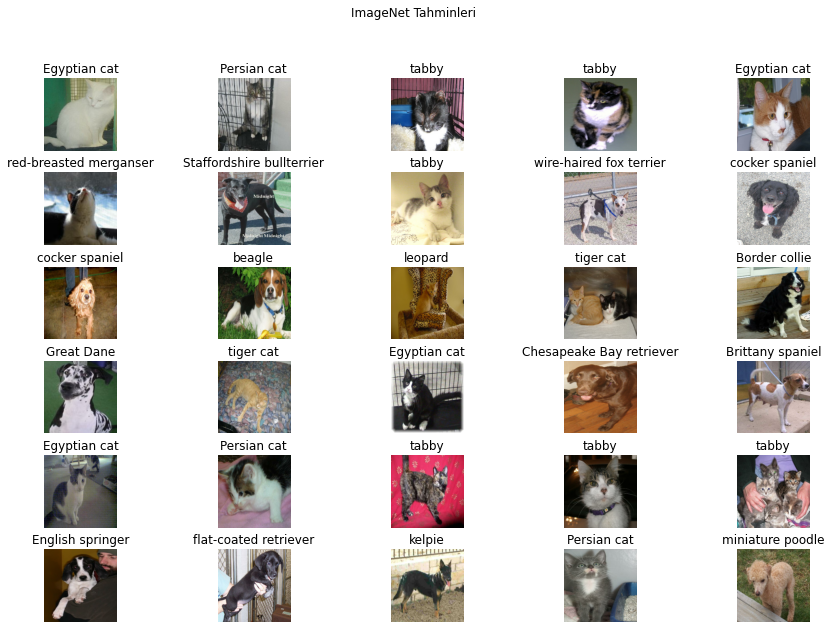

In [12]:
plt.figure(figsize=(15,10))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet Tahminleri")

## Transfer Öğrenimi Oluşumu

In [13]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

feature_extractor = hub.KerasLayer(URL,
                                   input_shape = (IMAGE_RES,IMAGE_RES,3))

In [14]:
feature_batch = feature_extractor(image_batch)
feature_batch.shape

TensorShape([32, 1280])

> Burada 32 görüntülerin sayısı 1280 ise alınan modelin son katman sayısıdır.

In [15]:
feature_extractor.trainable = False

> Alınan model önceden eğitilmiş modeldir, tahmin işlemi yaptırırken modeli tekrar eğitmeyeceğiz o yüzden eğitimi donduruyoruz. Sadece çıktı katmanında değişiklik yapacağız.

## Model Oluşturulması

In [16]:
model = tf.keras.Sequential([feature_extractor,
                             layers.Dense(2)])

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


## Modelin Derlenmesi


In [18]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

## Model Parametreleri

In [19]:
EPOCHS = 6

## Model Eğitimi

In [21]:
history = model.fit(train_batches,
                      epochs = EPOCHS,
                      validation_data = validation_batches)

Epoch 1/6
582/582 [==============================] - 100s 154ms/step - loss: 0.0512 - accuracy: 0.9822 - val_loss: 0.0288 - val_accuracy: 0.9901
Epoch 2/6
582/582 [==============================] - 94s 152ms/step - loss: 0.0305 - accuracy: 0.9892 - val_loss: 0.0219 - val_accuracy: 0.9926
Epoch 3/6
582/582 [==============================] - 93s 151ms/step - loss: 0.0251 - accuracy: 0.9913 - val_loss: 0.0188 - val_accuracy: 0.9937
Epoch 4/6
582/582 [==============================] - 93s 152ms/step - loss: 0.0217 - accuracy: 0.9920 - val_loss: 0.0170 - val_accuracy: 0.9943
Epoch 5/6
582/582 [==============================] - 133s 220ms/step - loss: 0.0186 - accuracy: 0.9939 - val_loss: 0.0234 - val_accuracy: 0.9916
Epoch 6/6
582/582 [==============================] - 93s 152ms/step - loss: 0.0181 - accuracy: 0.9939 - val_loss: 0.0122 - val_accuracy: 0.9967


## Modelin Doğruluk ve Kayıp Grafiği

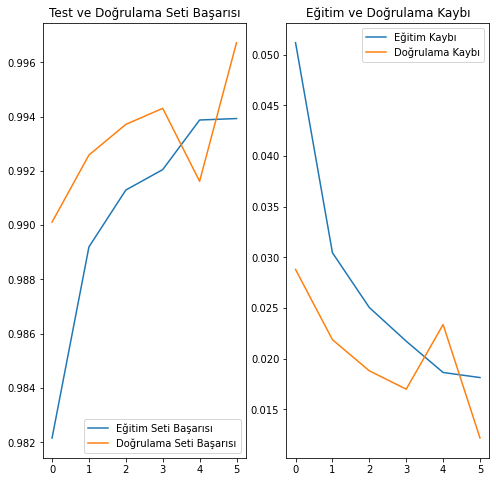

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Seti Başarısı')
plt.plot(epochs_range, val_acc, label='Doğrulama Seti Başarısı')
plt.legend(loc='lower right')
plt.title('Test ve Doğrulama Seti Başarısı')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.show()

## Tahminlerin Kontrolü

In [23]:
class_names = np.array(info.features['label'].names)
class_names #sınıf isimleri

array(['cat', 'dog'], dtype='<U3')

In [24]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch,axis = -1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

array(['cat', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'cat', 'dog',
       'dog', 'dog', 'dog', 'cat', 'cat', 'dog', 'dog', 'cat', 'cat',
       'dog', 'dog', 'cat', 'cat', 'cat', 'cat', 'cat', 'dog', 'dog',
       'dog', 'cat', 'dog', 'cat', 'cat'], dtype='<U3')

In [25]:
print("Sınıflar: ", label_batch)
print("Tahmin Sınıfları: ", predicted_ids)

Sınıflar:  [0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0]
Tahmin Sınıfları:  [0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 0]


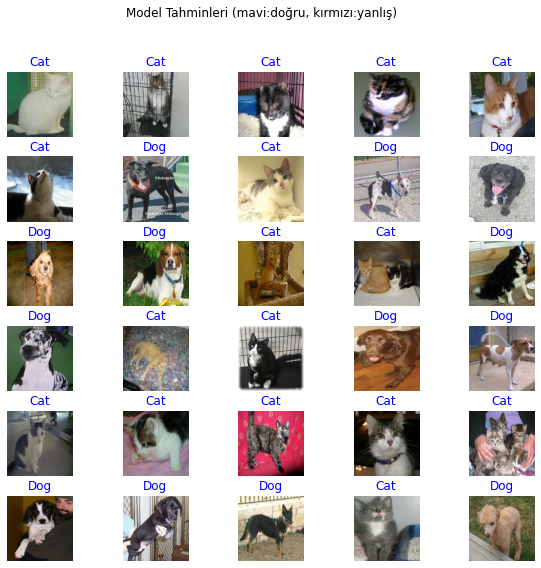

In [26]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model Tahminleri (mavi:doğru, kırmızı:yanlış)")